In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Thermobar as pt

# %matplotlib widget

In [2]:
# this allows figures to be saved as svg files with the text preserved
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
Plag_Wolf = pd.read_excel('PubData/Stock_Wolf_Plag.xlsx')
Plag_Wolf.columns = Plag_Wolf.columns + '_Plag'

In [4]:
# Load pyroxenes for Mg-in-plag thermometry calculations
color = {'03b': (0,0,0.56), '04b': 'b', '09g1': 'r', '09g2': 'y', '09g3': 'orange'}
Data = {}
for c in color:
    Data[c] = pd.read_excel('Data/FullEDSResults.xlsx', sheet_name=c)

Cpx = {}
for c in color:
    Cpx[c] = Data[c][Data[c]['Sample'].str.contains('Cpx')]
    Cpx[c] = Cpx[c].reset_index(drop = True)

In [5]:
Data = pd.read_excel('Data/FullPlagWDS.xlsx', sheet_name="NewData")
Plag = {}
for c in color:
    Plag[c] = Data.copy()
    Plag[c] = Plag[c][Plag[c]['Session'] == c]
    Plag[c] = Plag[c].reset_index(drop = True)

In [6]:
Plag_tern = {}
for c in color:
    Plag_tern[c] = pt.tern_points_fspar(fspar_comps=Plag[c])

Plag_tern_wolf = pt.tern_points_fspar(fspar_comps = Plag_Wolf)

/Users/gleesonm/anaconda3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


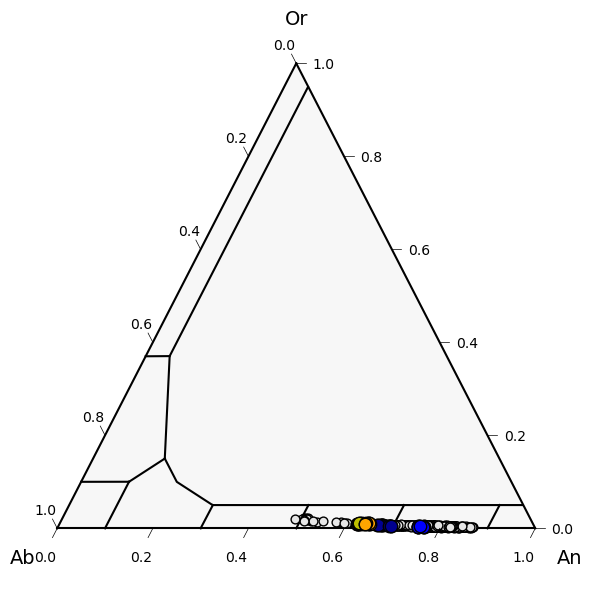

In [49]:
fig, tax = pt.plot_fspar_classification()
fig.tight_layout()

tax.scatter(Plag_tern_wolf, edgecolor = "k", marker = "o", facecolor = (0.9,0.9,0.9), s = 40)
for c in color:
    tax.scatter(Plag_tern[c], edgecolor="k", marker="o",facecolor=color[c],s=80)


In [8]:
# add noise to Plag analyses
Plag_noise = {}
for c in color:
    Plag[c]['Sample_ID_Plag'] = np.linspace(0,len(Plag[c]['SiO2_Plag'])-1,len(Plag[c]['SiO2_Plag']))

    Plag_noise_Err = Plag[c].loc[:,Plag[c].columns.str.contains('_Err')]
    Plag_noise[c] = pt.add_noise_sample_1phase(phase_comp=Plag[c], phase_err=Plag_noise_Err,
                            phase_err_type="Abs", duplicates=2000, err_dist="normal")

All negative numbers replaced with zeros. If you wish to keep these, set positive=False
All negative numbers replaced with zeros. If you wish to keep these, set positive=False
All negative numbers replaced with zeros. If you wish to keep these, set positive=False
All negative numbers replaced with zeros. If you wish to keep these, set positive=False
All negative numbers replaced with zeros. If you wish to keep these, set positive=False


In [9]:
import random
P = {}
for c in color:
    Plag_noise[c]['MgO_Cpx'] = np.random.normal(Cpx[c]['MgO_Cpx'].mean(), Cpx[c]['MgO_Cpx'].std(), 2000*len(Plag[c]['SiO2_Plag']))
    P[c] = [random.uniform(0.2, 0.7) for _ in range(2000*len(Plag[c]['SiO2_Plag']))]

In [10]:
## define plag T functions

def PlagT(Plag,P, Cpx_MgO):
    T = (14265 + 487*P**2)/(-np.log(Plag['MgO_Plag'].values/Cpx_MgO) + 5.15 + 0.75*Plag['An'].values**2) - 273.15
    return T

In [11]:
for c in color: 
    Plag_noise[c]['An'] = (Plag_noise[c]['CaO_Plag']/56.0774)/(Plag_noise[c]['CaO_Plag']/56.0774 + 
                    2*Plag_noise[c]['Na2O_Plag']/61.9789 + 2*Plag_noise[c]['K2O_Plag']/94.2)
    Plag[c]['An'] = (Plag[c]['CaO_Plag']/56.0774)/(Plag[c]['CaO_Plag']/56.0774 + 
                    2*Plag[c]['Na2O_Plag']/61.9789 + 2*Plag[c]['K2O_Plag']/94.2)

Plag_Wolf['An'] = (Plag_Wolf['CaO_Plag']/56.0774)/(Plag_Wolf['CaO_Plag']/56.0774 + 
                    2*Plag_Wolf['Na2O_Plag']/61.9789 + 2*Plag_Wolf['K2O_Plag']/94.2)

In [12]:
for c in color:
    Plag_noise[c]['T_C'] = PlagT(Plag_noise[c], np.array(P[c]), Plag_noise[c]['MgO_Cpx'])

In [13]:
for c in color:
    Plag[c]['T_C'] = np.zeros(len(Plag[c]['SiO2_Plag']))
    Plag[c]['T_C_err'] = np.zeros(len(Plag[c]['SiO2_Plag']))


    Plag_noise[c]['T_C'].loc[Plag_noise[c]['T_C'] < 0.0] = np.nan

    for i in range(len(Plag[c]['T_C'])):
        Plag[c].loc[i, 'T_C'] = np.nanmean(Plag_noise[c]['T_C'].loc[i*2000:i*2000+2000])
        Plag[c].loc[i, 'T_C_err'] = np.nanstd(Plag_noise[c]['T_C'].loc[i*2000:i*2000+2000])

In [14]:
excel_writer = pd.ExcelWriter('Plag_noise.xlsx', engine='xlsxwriter')
for c in color:
    Plag_noise[c].to_excel(excel_writer, sheet_name=c, index=False)

excel_writer.close()

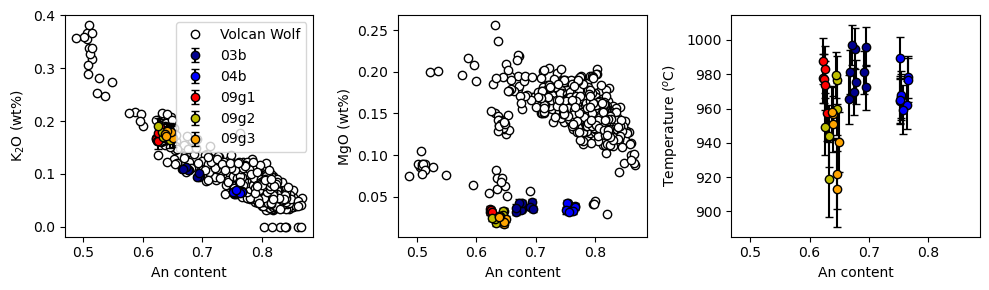

In [51]:
f, a = plt.subplots(1,3, figsize = (10,3), sharex = True)
a[0].plot(Plag_Wolf['An'],Plag_Wolf['K2O_Plag'], 'ok', mfc = 'w', label = 'Volcan Wolf')
for c in color:
    a[0].errorbar(Plag[c]['An'], Plag[c]['K2O_Plag'], yerr = Plag[c]['K2O_Plag_Err'], 
                marker = 'o', mfc = color[c], mec = 'k', linestyle = 'None',ecolor='k', label = c, capsize = 3)


a[1].plot(Plag_Wolf['An'],Plag_Wolf['MgO_Plag'], 'ok', mfc = 'w', label = 'Volcan Wolf')
for c in color:
    a[1].errorbar(Plag[c]['An'], Plag[c]['MgO_Plag'], yerr = Plag[c]['MgO_Plag_Err'], 
                marker = 'o', mfc = color[c], mec = 'k', linestyle = 'None',ecolor='k', capsize = 3)

for c in color:
    a[2].errorbar(Plag[c]['An'], Plag[c]['T_C'], yerr = Plag[c]['T_C_err'], 
                marker = 'o', mfc = color[c], mec = 'k', linestyle = 'None',ecolor='k', capsize=3)

for i in range(3):
    a[i].set_xlabel('An content')

a[0].set_ylabel('K$_2$O (wt%)')
a[1].set_ylabel('MgO (wt%)')
a[2].set_ylabel('Temperature ($^o$C)')

a[0].legend(loc='upper right')

f.tight_layout()
